web: gunicorn app: app

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [5]:
data = pd.read_csv("heart.csv")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2.0,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0.0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0.0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1.0,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3.0,2,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1259 non-null   int64  
 1   sex       1259 non-null   int64  
 2   cp        1259 non-null   int64  
 3   trestbps  1259 non-null   int64  
 4   chol      1259 non-null   int64  
 5   fbs       1259 non-null   int64  
 6   restecg   1259 non-null   int64  
 7   thalach   1259 non-null   int64  
 8   exang     1259 non-null   int64  
 9   oldpeak   1259 non-null   float64
 10  slope     1259 non-null   int64  
 11  ca        1259 non-null   float64
 12  thal      1259 non-null   int64  
 13  target    1259 non-null   int64  
dtypes: float64(2), int64(12)
memory usage: 137.8 KB


In [ ]:
data.target.value_counts()

 1    526
 0    499
-1    234
Name: target, dtype: int64

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1259.0,44.131056,23.072833,-1.0,41.0,52.0,59.00,77.0
sex,1259.0,0.380461,0.779690,-1.0,0.0,1.0,1.00,1.0
cp,1259.0,0.581414,1.197641,-1.0,0.0,0.0,2.00,3.0
trestbps,1259.0,106.964257,53.971474,-1.0,110.0,125.0,140.00,200.0
chol,1259.0,200.092137,106.797556,-1.0,180.0,228.0,267.00,564.0
fbs,1259.0,-0.064337,0.550898,-1.0,0.0,0.0,0.00,1.0
restecg,1259.0,0.245433,0.762371,-1.0,0.0,0.0,1.00,2.0
thalach,1259.0,121.213662,61.994727,-1.0,112.5,144.0,162.00,202.0
exang,1259.0,0.088165,0.672663,-1.0,0.0,0.0,1.00,1.0
oldpeak,1259.0,0.686497,1.331826,-1.0,0.0,0.3,1.45,6.2


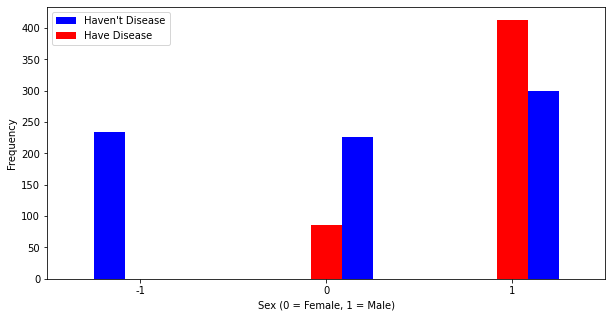

In [ ]:
pd.crosstab(data.sex, data.target).plot(kind="bar",figsize=(10,5),color=['blue','red' ])

plt.xlabel('Sex (0 = Female, 1 = Male)') # X-Label

plt.xticks(rotation=0) # Get or set the current tick locations and labels of the x-axis.

plt.legend(["Haven't Disease", "Have Disease"]) # legend = Index

plt.ylabel('Frequency') # X-Label

plt.show() # Help to show our diagram

In [ ]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)

IQR = Q3 - Q1

((data < (Q1 - 1.5 * IQR)) | (data < (Q3 - 1.5 * IQR))).sum()

age         238
sex         234
cp            0
trestbps    241
chol        240
fbs         234
restecg     234
thalach     238
exang       234
oldpeak     234
slope       308
ca            0
thal        305
target      234
dtype: int64

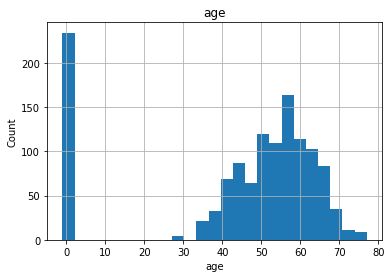

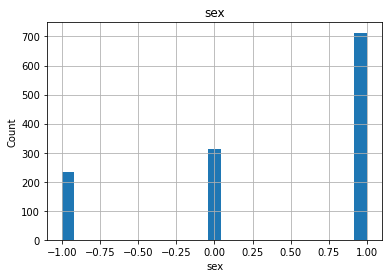

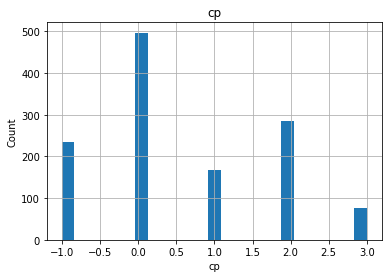

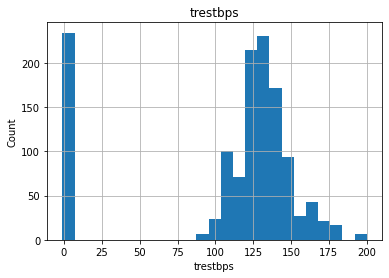

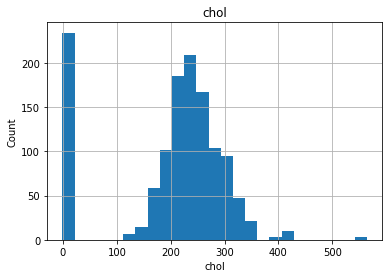

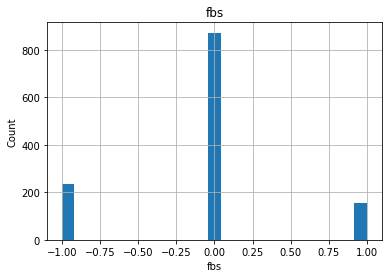

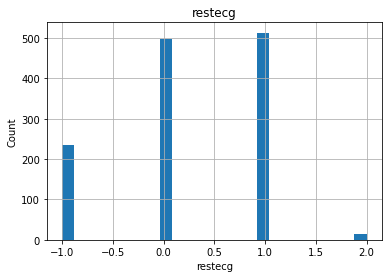

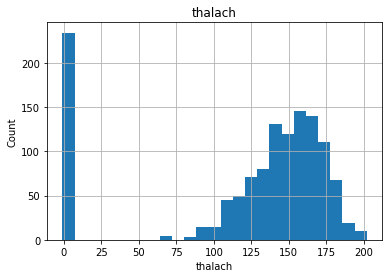

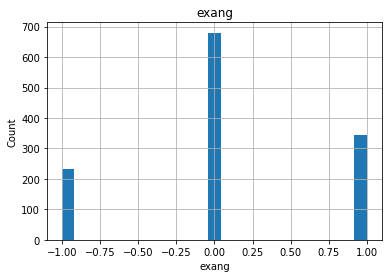

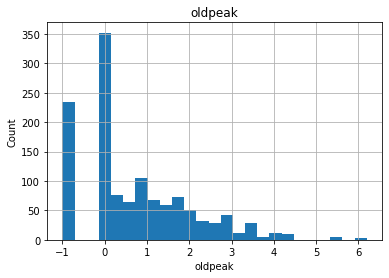

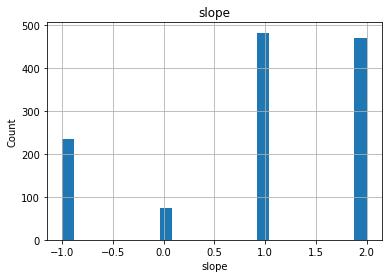

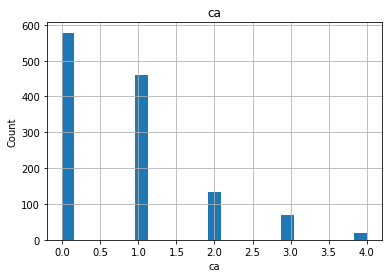

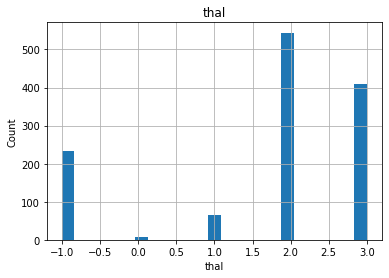

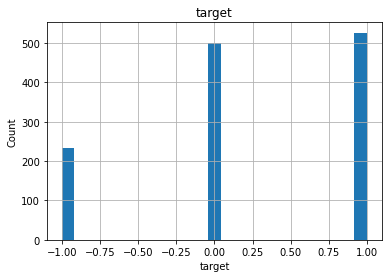

In [ ]:
for feature in data:
    dataset = data.copy()
    dataset[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()


c:\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


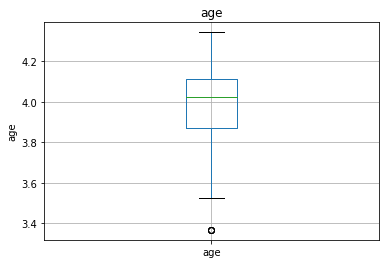

c:\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


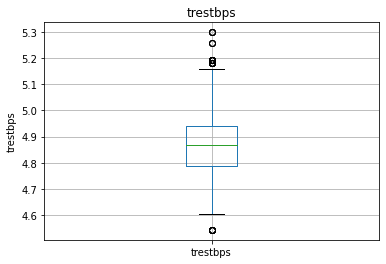

c:\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


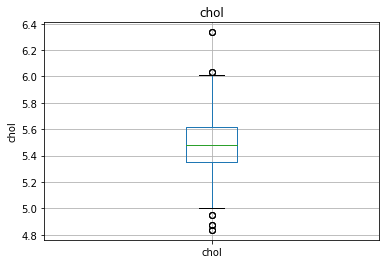

c:\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


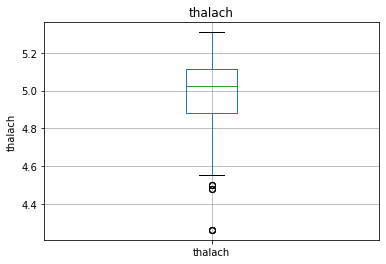

In [ ]:
for feature in data:
    dataset = data.copy()

    if 0 in dataset[feature].unique():
        pass
    else:
        dataset[feature] = np.log(dataset[feature])
        dataset.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()



In [ ]:
outliers = []

def detect_outliers(values):
    Threshold = 3
    mean_val = np.mean(values)
    std_val = np.std(values)

    for i in values:
        z_score = (i - mean_val) / std_val
        if np.abs(z_score) > Threshold:
            outliers.append(i)
    return outliers

out = detect_outliers(data['age'])
out


[]

In [ ]:
outliers = []

def detect_outliers(values):
    Threshold = 3
    mean_val = np.mean(values)
    std_val = np.std(values)

    for i in values:
        z_score = (i - mean_val) / std_val
        if np.abs(z_score) > Threshold:
            outliers.append(i)
    
    return outliers

out = detect_outliers(data['trestbps'])
out


[]

In [ ]:
outliers = []

def detect_outliers(values):
    Threshold = 3
    mean_val = np.mean(values)
    std_val = np.std(values)

    for i in values:
        z_score = (i - mean_val) / std_val
        if np.abs(z_score) > Threshold:
            outliers.append(i)
    return outliers

out = detect_outliers(data['chol'])
out


[564, 564, 564]

In [ ]:
outliers = []

def detect_outliers(values):
    Threshold = 3
    mean_val = np.mean(values)
    std_val = np.std(values)

    for i in values:
        z_score = (i - mean_val) / std_val
        if np.abs(z_score) > Threshold:
            outliers.append(i)
    return outliers

out = detect_outliers(data['thalach'])
out


[]

<AxesSubplot: >

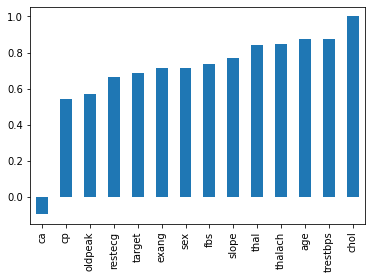

In [ ]:
data.corr()['chol'].sort_values().plot(kind='bar')

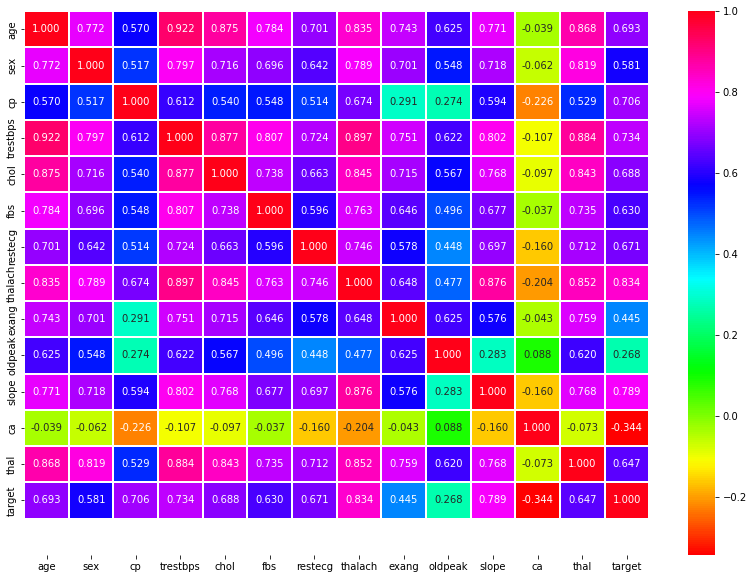

In [ ]:
plt.figure(figsize=(14,10)) # Help to set figure size

sns.heatmap(data.corr(),annot=True,cmap='hsv',fmt='.3f',linewidths=2)

plt.ylim(15,0) # show us the exact number of values we want

plt.show()

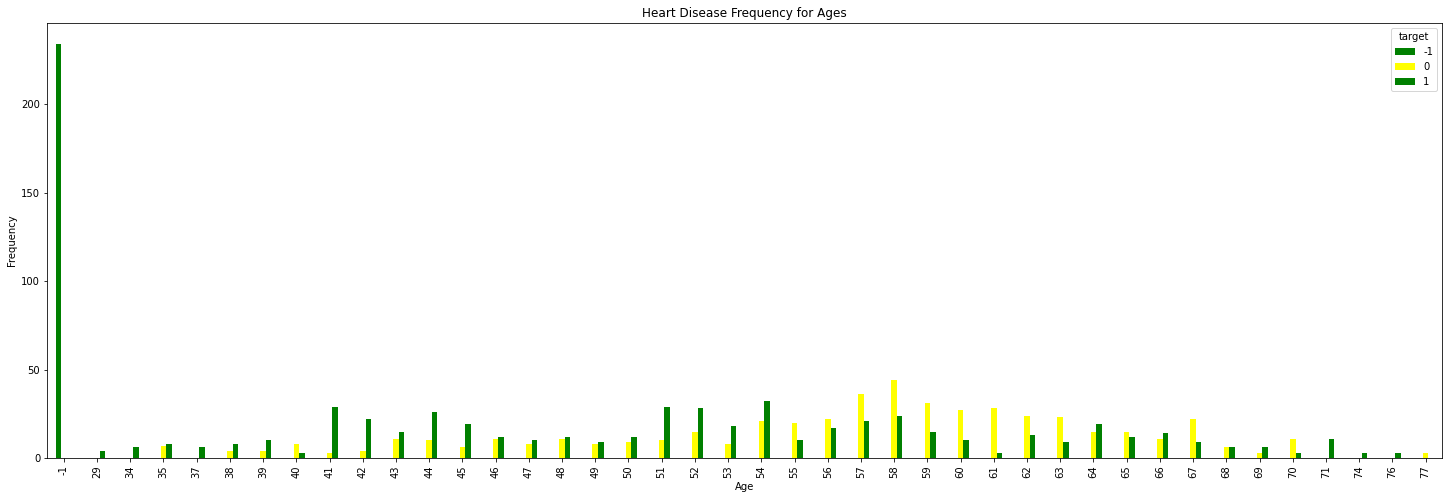

In [ ]:
pd.crosstab(data.age,data.target).plot(kind="bar",figsize=(25,8),color=['green','yellow' ])
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop('target', axis=1).values
y = data['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()

lr_model.fit(X_train,y_train)

lr_pred = lr_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,lr_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        41
           0       0.90      0.89      0.89        97
           1       0.90      0.91      0.91       114

    accuracy                           0.92       252
   macro avg       0.93      0.93      0.93       252
weighted avg       0.92      0.92      0.92       252



In [ ]:
print(confusion_matrix(y_test,lr_pred))

[[ 41   0   0]
 [  0  86  11]
 [  0  10 104]]


In [ ]:
from sklearn import svm

clf_model = svm.SVC(kernel='rbf')

clf_model.fit(X_train,y_train)

clf_pred = clf_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,clf_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        41
           0       0.94      0.95      0.94        97
           1       0.96      0.95      0.95       114

    accuracy                           0.96       252
   macro avg       0.96      0.97      0.97       252
weighted avg       0.96      0.96      0.96       252



In [ ]:
print(confusion_matrix(y_test,clf_pred))

[[ 41   0   0]
 [  0  92   5]
 [  0   6 108]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier



rf_model = RandomForestClassifier(n_estimators=1)

rf_model.fit(X_train,y_train)

rf_pred = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, rf_pred)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        41
           0       0.96      0.96      0.96        97
           1       0.96      0.96      0.96       114

    accuracy                           0.97       252
   macro avg       0.97      0.97      0.97       252
weighted avg       0.97      0.97      0.97       252



In [ ]:
print(confusion_matrix(y_test,rf_pred))

[[ 41   0   0]
 [  0  93   4]
 [  0   4 110]]


In [ ]:

accuracy_lr = accuracy_score(y_test, lr_pred)
accuracy_svm = accuracy_score(y_test, clf_pred)
accuracy_rf = accuracy_score(y_test, rf_pred)

print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")
print(f"SVM Accuracy: {accuracy_svm:.4f}")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")


Logistic Regression Accuracy: 0.9167
SVM Accuracy: 0.9563
Random Forest Accuracy: 0.9683


In [ ]:
# RANDOM FOREST GAVE US THE BEST RESULT

import joblib
joblib.dump(rf_model,"Heart_Disease_Prediction.joblib")

['Heart_Disease_Prediction.joblib']

In [ ]:
# Testing our model performance
m = joblib.load('Heart_Disease_Prediction.joblib')
m.predict([[55,1,3,145,233,0,0,150,0,2.2,0,0,1]])

array([0], dtype=int64)